In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision import transforms

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# # 存放结果文件
# os.mkdir('output')

# # 存放训练得到的模型权重
# os.mkdir('checkpoint')


# # 存放生成的图表
# os.mkdir('图表')

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])


# 准备数据集
dataset_dir = 'music'
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')

from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)


# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：类别 到 索引号
train_dataset.class_to_idx
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)


num_classes=6

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=num_classes,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=num_classes,
                         shuffle=False,
                         num_workers=4
                        )

# 加载预训练的ResNet模型
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # 假设num_classes为乐器的类别数

# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.Adam(model.fc.parameters())

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 训练模型
num_epochs = 30
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

model = model.to(device)
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad() # 清除梯度
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签放到device上
        outputs = model(inputs) # 将输入数据输入神经网络模型，得到模型的输出
        loss = criterion(outputs, labels) # 由logit计算当前batch中，每个样本的平均交叉熵损失函数值
        loss.backward() # 反向传播
        optimizer.step() # 优化更新
        

        running_loss += loss.item()#累加每个batch
         #_ 用于接收最大值，而 predicted 则接收最大值对应的索引，即模型的预测结果
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签放到device上
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(running_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 30/30 [04:38<00:00,  9.29s/it]


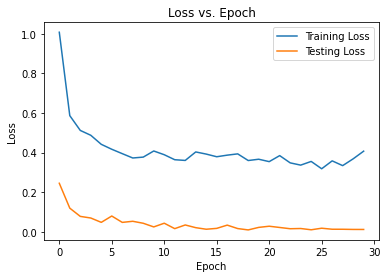

In [2]:
# 绘制损失函数值随迭代次数变化的曲线图
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs),     test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

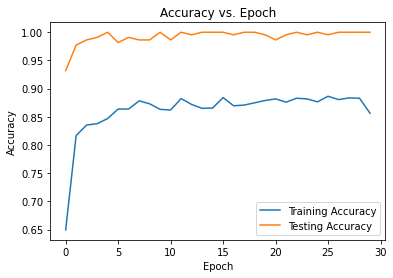

In [3]:
# 绘制分类准确率随回合数变化的曲线图
plt.figure()
plt.plot(range(num_epochs), train_accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

In [4]:
print('测试集上的准确率为 {:.3f} %'.format(100 * correct_test / total_test))

测试集上的准确率为 100.000 %


In [5]:
torch.save(model, 'checkpoint/music_pytorch_C1.pth')